In [1]:
cd ..

/home/luco/python/rnn


In [2]:
%matplotlib inline

# Sequence Classification

** Objective: ** Capture annual seasonality

** Task: ** Classify 12-length sequences of monthly sales of new one-family houses according to which month the sequence begins with (ranging from Jan to Dec)

** Method: ** Bidirectional LSTM recurrent neural net

** Evaluation: ** Holdout, categorical accuracy, confusion matrix

In [3]:
import numpy as np

from pandas import read_csv
from matplotlib import pyplot
from seaborn import heatmap

from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from keras.activations import relu, softmax
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, adagrad, adadelta, rmsprop
from keras.metrics import categorical_accuracy

Using TensorFlow backend.


## Data

In [4]:
data = read_csv("data/monthly-sales-of-new-onefamily-h.csv", delimiter=";")
data

,Month,Monthly sales of new one-family houses sold in th e USA since 1973
0,1973-01,55
1,1973-02,60
2,1973-03,68
3,1973-04,63
4,1973-05,65
5,1973-06,61
6,1973-07,54
7,1973-08,52
8,1973-09,46
9,1973-10,42


In [5]:
vals = data["Monthly sales of new one-family houses sold in th e USA since 1973"].values

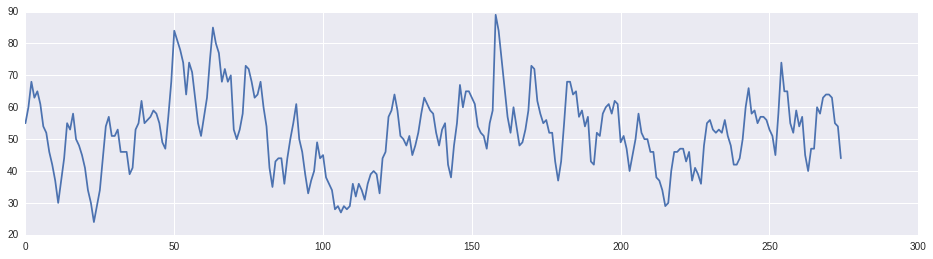

In [6]:
pyplot.subplots(figsize=(16,4))
pyplot.plot(vals)

If we look closer, there is an apparent annual seasonality in the data - peaks during springs, craters during winters

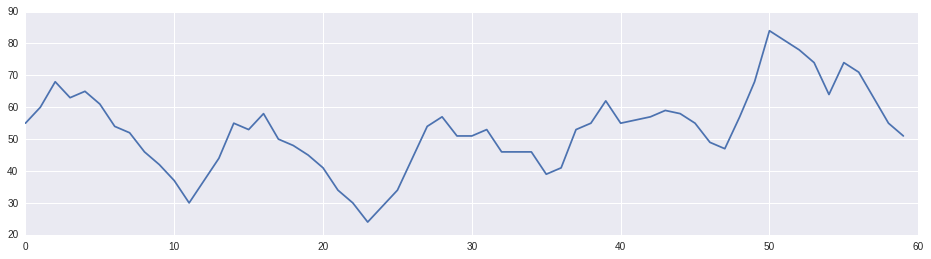

In [7]:
pyplot.subplots(figsize=(16,4))
pyplot.plot(vals[:60])  # first 60 months

### Year 1995 (the last one) contains only 11 months $\longrightarrow$ discard it

In [8]:
vals = vals[:-11]
print len(vals)

264


### Sanity checks

In [9]:
print len(vals) % 12 == 0
print len(vals) / 12 == 1995 - 1973

True
True


## Vectorizing Data

In [10]:
eye = np.eye(12)  # identity matrix

x = np.zeros((264 - 11, 12, 1))
y = np.zeros((264 - 11, 12))

for i in range(264 - 11):
    x[i,:,0]= vals[i:i+12]
    y[i,:] = eye[i % 12]

## Holdout
### Split into Train/Test Sets

In [11]:
thr = 16 * 12  # NB_YEARS * 12 (months)

x_train_temp = x[:thr]
y_train_temp = y[:thr]

x_test = x[thr:]
y_test = y[thr:]

In [12]:
len(x_train_temp), len(x_test)

(192, 61)

## Noisy Data Enlargement

We can do the task with no special preprocessing, but there is way too few data - the model would overfit easily.

It is possible to gain 10-20% more accurracy by making noisy copies of the train set.

In [13]:
nb_copies = 50

x_train = np.concatenate([
    x_train_temp
    + 30 * np.random.random() - 15  # global offset with a (possibly large) scalar
    + 2 * np.random.random(x_train_temp.shape) - 1  # small element-wise offset
    for _ in range(nb_copies)
])
y_train = np.concatenate([
    y_train_temp
    for _ in range(nb_copies)
])

In [14]:
print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(9600, 12, 1)
(9600, 12)
(61, 12, 1)
(61, 12)


## Model Architecture

Let's use a popular *Keras* deep learning library to define the model's architecture in a shortest and clearest possible way with best practices configured as a default behavior.  

In natural language - 2-layered bidirectional LSTM followed by two dense layers with relu activations followed by softmax classifier.

In [15]:
def get_model(weights_filename=None):
    
    inp = Input(shape=(None, 1))  # variable-length list of integers

    l = Bidirectional(LSTM(128, return_sequences=True), merge_mode="concat")(inp)
    l = Dropout(0.6)(l)
    l = Bidirectional(LSTM(64), merge_mode="concat")(l)
    l = Dropout(0.3)(l)
    
    l = Dense(32, activation=relu)(l)
    l = Dropout(0.2)(l)
    l = Dense(32, activation=relu)(l)
    l = Dropout(0.2)(l)
    
    out = Dense(12, activation=softmax)(l)
    
    model = Model(inputs=inp, outputs=out)
    
    model.compile(
        loss=categorical_crossentropy,
        optimizer=rmsprop(),
        metrics=[categorical_accuracy]
    )
    
    if weights_filename is not None:
        model.load_weights(weights_filename)
    
    return model

## Model & Training

In [16]:
model = get_model()

We can watch losses and accurracies on train and test sets throughout the training.

In [17]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test),
          verbose=1, epochs=5, batch_size=64)

Train on 9600 samples, validate on 61 samples
Epoch 1/5
9600/9600 [==============================] - 22s - loss: 2.4704 - categorical_accuracy: 0.1032 - val_loss: 2.2595 - val_categorical_accuracy: 0.1639
Epoch 2/5
9600/9600 [==============================] - 21s - loss: 1.8495 - categorical_accuracy: 0.2948 - val_loss: 1.0657 - val_categorical_accuracy: 0.6721
Epoch 3/5
9600/9600 [==============================] - 24s - loss: 1.2822 - categorical_accuracy: 0.4912 - val_loss: 0.9113 - val_categorical_accuracy: 0.7049
Epoch 4/5
9600/9600 [==============================] - 22s - loss: 0.9760 - categorical_accuracy: 0.6192 - val_loss: 0.6647 - val_categorical_accuracy: 0.6721
Epoch 5/5
9600/9600 [==============================] - 21s - loss: 0.7934 - categorical_accuracy: 0.6905 - val_loss: 0.8238 - val_categorical_accuracy: 0.7377


#### Note

In first few epochs, losses and accurracies on validation set are higher than on train set.  Apparently, that is because dropout is not used on validation set. 

After 5. epoch, the acc on train set is already 89% without dropout.

In [18]:
model.evaluate(x=x_train, y=y_train)

9568/9600 [============================>.] - ETA: 0s

[0.35827225764592491, 0.89718750000000003]

It can go up to 100%, but it hurts the acc on test set at that point.

## Confusion Matrix

We are interested in confusion matrix as confusing March with April is more tolerable than confusing March with September.

In [19]:
predictions = model.predict(x_test)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5]), <a list of 12 Text yticklabel objects>)

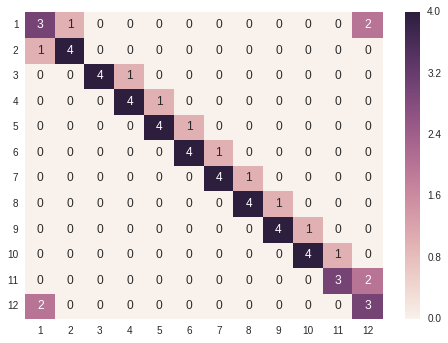

In [20]:
confusion_matrix = np.zeros((12, 12), dtype=np.int32)

for i in range(len(y_test)):

    row_i = np.argmax(y_test[i])
    col_i = np.argmax(predictions[i])
    
    confusion_matrix[row_i, col_i] += 1

heatmap(confusion_matrix, annot=True,
        xticklabels=range(1, 13),
        yticklabels=range(1, 13))
pyplot.yticks(rotation=0)

We can see that the model never confuses months beyond the neighborhooding ones (on test set).  And that is quite nice.

## Conclusion

Bidirectional LSTM is perfectly capable of capturing seasonal variations.

When there is too few data, better results can be achieved with noisy data enlargement.